In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [13]:
# Folder path (update agar alag ho)
path = "uidai_data/api_data_aadhar_enrolment/"

files = [
    "api_data_aadhar_enrolment_0_500000.csv",
    "api_data_aadhar_enrolment_500000_1000000.csv",
    "api_data_aadhar_enrolment_1000000_1006029.csv"
]

dfs = [pd.read_csv(path + f) for f in files]

aadhaar_df = pd.concat(dfs, ignore_index=True)

print("Shape:", aadhaar_df.shape)
print(aadhaar_df.columns)


Shape: (1006029, 7)
Index(['date', 'state', 'district', 'pincode', 'age_0_5', 'age_5_17',
       'age_18_greater'],
      dtype='object')


In [14]:
aadhaar_df['date'] = pd.to_datetime(
    aadhaar_df['date'],
    dayfirst=True,
    errors='coerce'
)

aadhaar_df['year'] = aadhaar_df['date'].dt.year

# Date column ab kaam ka nahi
aadhaar_df = aadhaar_df.drop(columns=['date'])


In [15]:
district_year_df = aadhaar_df.groupby(
    ['state', 'district', 'year'],
    as_index=False
).sum()


In [17]:
# Convert to string
district_year_df['state'] = district_year_df['state'].astype(str)
district_year_df['district'] = district_year_df['district'].astype(str)

# Remove numeric placeholders like 100000
district_year_df = district_year_df[
    ~district_year_df['state'].str.isnumeric() &
    ~district_year_df['district'].str.isnumeric()
]


In [21]:
district_year_df['state'] = district_year_df['state'].replace({
    'Andaman & Nicobar Islands': 'Andaman and Nicobar Islands'
})


In [23]:
district_year_df['total_enrolment'] = (
    district_year_df['age_0_5'] +
    district_year_df['age_5_17'] +
    district_year_df['age_18_greater']
)


In [25]:
district_year_df['child_ratio'] = (
    district_year_df['age_0_5'] /
    district_year_df['total_enrolment']
)


In [27]:
district_year_df = district_year_df.replace([np.inf, -np.inf], np.nan)
district_year_df = district_year_df.fillna(0)


In [29]:
district_year_df['AISI_level'] = 'Medium'

# 🔴 HIGH STRESS
district_year_df.loc[
    (district_year_df['total_enrolment'] < 10) |
    (district_year_df['child_ratio'] < 0.15),
    'AISI_level'
] = 'High'

# 🟢 LOW STRESS
district_year_df.loc[
    (district_year_df['total_enrolment'] >= 50) &
    (district_year_df['child_ratio'] >= 0.30),
    'AISI_level'
] = 'Low'


In [31]:
district_year_df[
    ['district', 'total_enrolment', 'child_ratio', 'AISI_level']
].head(20)


,district,total_enrolment,child_ratio,AISI_level
1,Andamans,75,0.933333,Low
2,Nicobars,1,1.000000,High
3,South Andaman,38,1.000000,Medium
4,Nicobar,75,0.853333,Low
5,North And Middle Andaman,132,0.969697,Low
6,South Andaman,190,0.936842,Low
7,Adilabad,1419,0.801268,Low
8,Alluri Sitharama Raju,1255,0.880478,Low
9,Anakapalli,543,0.963168,Low
10,Anantapur,4415,0.926161,Low


In [33]:
district_year_df['AISI_level'].value_counts()


AISI_level
Low       896
High       95
Medium     78
Name: count, dtype: int64

In [35]:
district_year_df.to_csv("AISI_Final_Output.csv", index=False)


(95, 10)


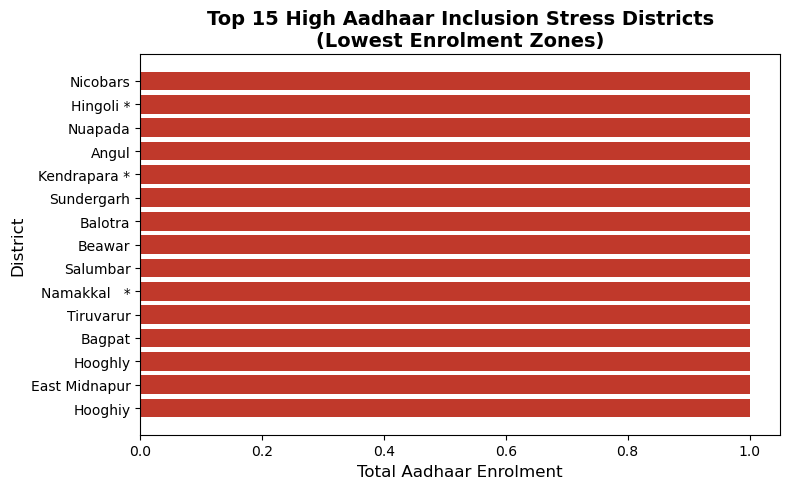

In [37]:
district_year_df

district_year_df['state'] = (
    district_year_df['state']
    .str.strip()
    .str.title()
)

district_year_df['district'] = (
    district_year_df['district']
    .str.strip()
    .str.title()
)
high_stress = district_year_df[
    district_year_df['AISI_level'] == 'High'
]

print(high_stress.shape)
high_stress.head()
top_high_stress = (
    high_stress
    .sort_values(by='total_enrolment', ascending=True)
    .head(15)
)

plt.figure(figsize=(8, 5))

plt.barh(
    top_high_stress['district'],
    top_high_stress['total_enrolment'],
    color='#c0392b'
)

plt.xlabel("Total Aadhaar Enrolment", fontsize=12)
plt.ylabel("District", fontsize=12)

plt.title(
    "Top 15 High Aadhaar Inclusion Stress Districts\n(Lowest Enrolment Zones)",
    fontsize=14,
    fontweight='bold'
)

plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


plt.figure(figsize=(14, 6))
plt.bar(high_stress['district'], high_stress['total_enrolment'])
plt.xticks(rotation=75, ha='right', fontsize=8)
plt.xlabel("District")
plt.ylabel("Total Enrolment")
plt.title("High Aadhaar Inclusion Stress Districts")
plt.tight_layout()
plt.show()


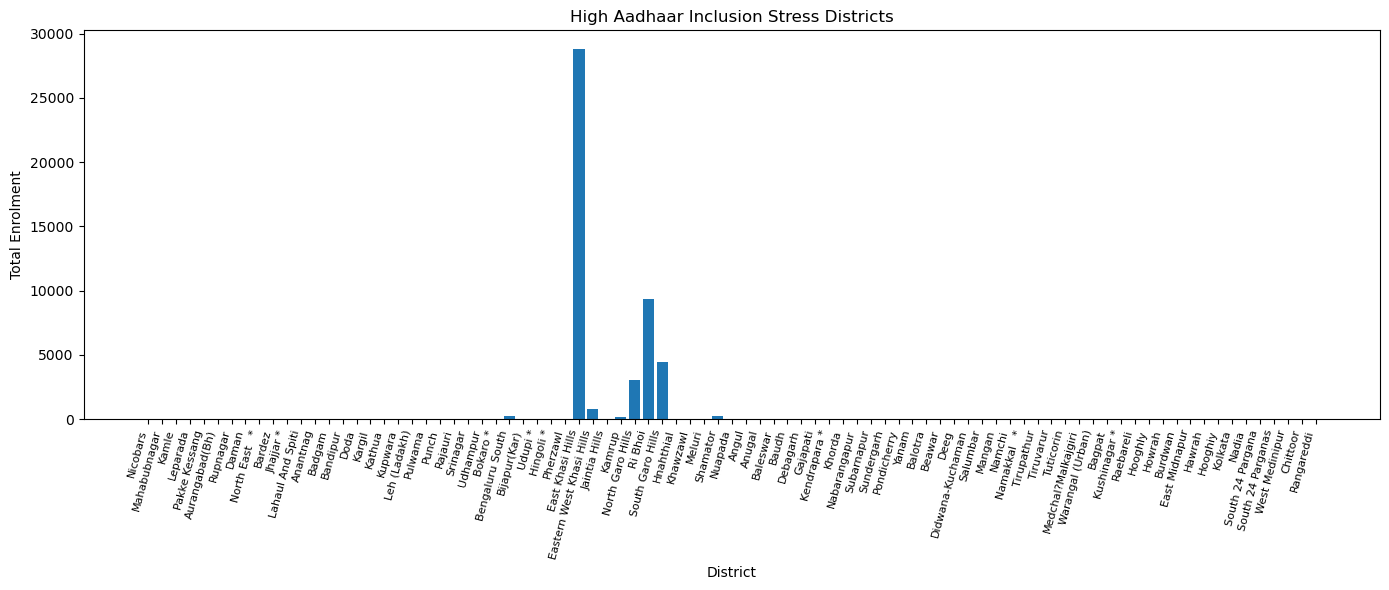

In [40]:
plt.figure(figsize=(14, 6))
plt.bar(high_stress['district'], high_stress['total_enrolment'])
plt.xticks(rotation=75, ha='right', fontsize=8)
plt.xlabel("District")
plt.ylabel("Total Enrolment")
plt.title("High Aadhaar Inclusion Stress Districts")
plt.tight_layout()
plt.show()


<h2> VOLUME vs CHILD RATIO </h2>

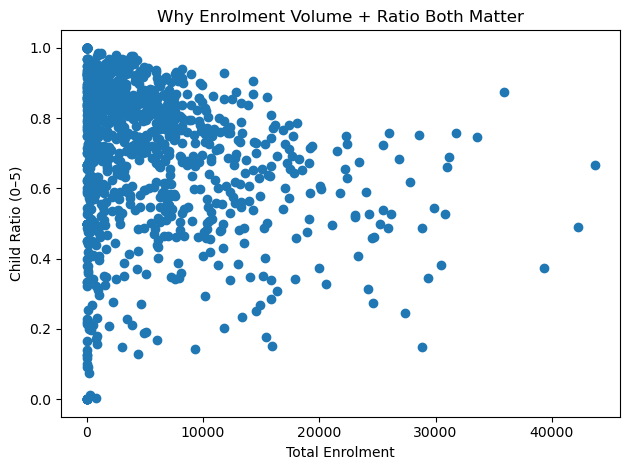

In [43]:
plt.figure()
plt.scatter(
    district_year_df['total_enrolment'],
    district_year_df['child_ratio']
)
plt.xlabel("Total Enrolment")
plt.ylabel("Child Ratio (0–5)")
plt.title("Why Enrolment Volume + Ratio Both Matter")
plt.tight_layout()
plt.show()


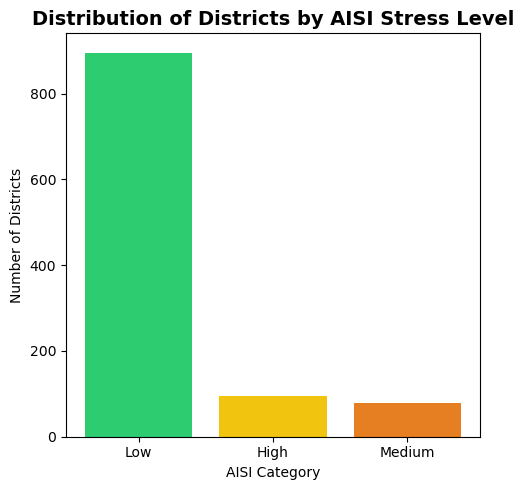

In [45]:
plt.figure(figsize=(5,5))

counts = district_year_df['AISI_level'].value_counts()
colors = ['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c']

plt.bar(counts.index, counts.values, color=colors)
plt.title("Distribution of Districts by AISI Stress Level", fontsize=14, fontweight='bold')
plt.xlabel("AISI Category")
plt.ylabel("Number of Districts")
plt.tight_layout()
plt.savefig("visi_district_stress_distribution.png", dpi=300)
plt.show()


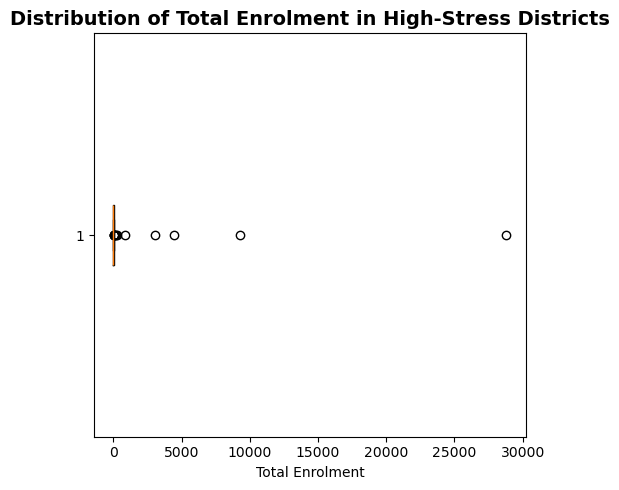

In [47]:
plt.figure(figsize=(5,5))
plt.boxplot(high_stress['total_enrolment'], vert=False)
plt.title("Distribution of Total Enrolment in High-Stress Districts", fontsize=14, fontweight='bold')
plt.xlabel("Total Enrolment")
plt.tight_layout()
plt.savefig("visi_highstress_boxplot.png", dpi=300)
plt.show()


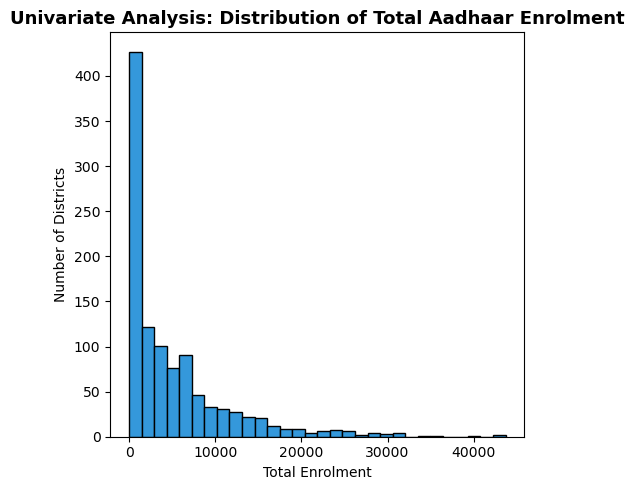

In [49]:
plt.figure(figsize=(5, 5))

plt.hist(
    district_year_df['total_enrolment'],
    bins=30,
    color='#3498db',
    edgecolor='black'
)

plt.title("Univariate Analysis: Distribution of Total Aadhaar Enrolment",
          fontsize=13, fontweight='bold')
plt.xlabel("Total Enrolment")
plt.ylabel("Number of Districts")

plt.tight_layout()
plt.savefig("slide6_univariate_enrolment_dist.png", dpi=300)
plt.show()


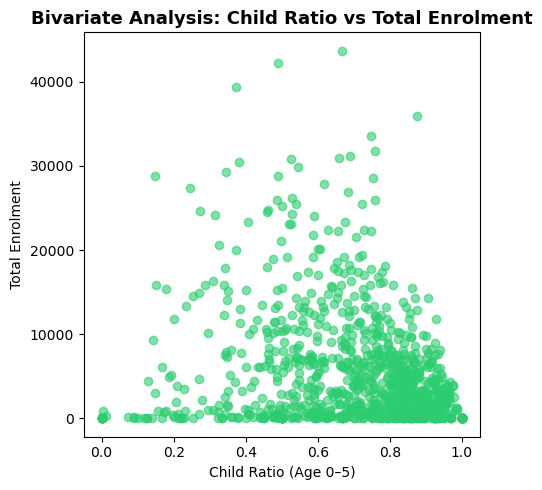

In [51]:
plt.figure(figsize=(5, 5))

plt.scatter(
    district_year_df['child_ratio'],
    district_year_df['total_enrolment'],
    alpha=0.6,
    color='#2ecc71'
)

plt.title("Bivariate Analysis: Child Ratio vs Total Enrolment",
          fontsize=13, fontweight='bold')
plt.xlabel("Child Ratio (Age 0–5)")
plt.ylabel("Total Enrolment")

plt.tight_layout()
plt.savefig("slide6_bivariate_childratio.png", dpi=300)
plt.show()


<Figure size 800x600 with 0 Axes>

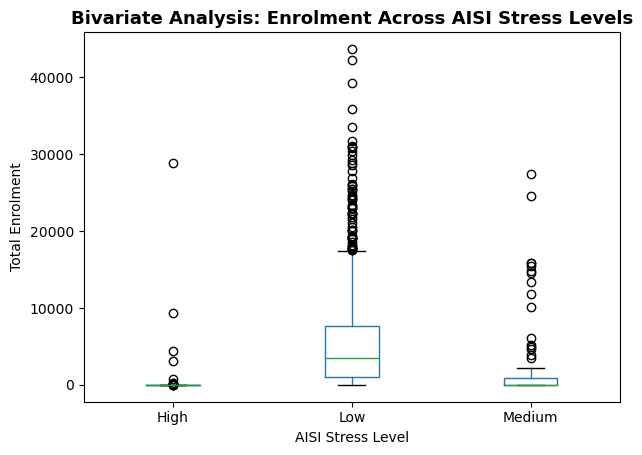

In [53]:
plt.figure(figsize=(8, 6))

district_year_df.boxplot(
    column='total_enrolment',
    by='AISI_level',
    grid=False
)

plt.title("Bivariate Analysis: Enrolment Across AISI Stress Levels",
          fontsize=13, fontweight='bold')
plt.suptitle("")  # remove default subtitle
plt.xlabel("AISI Stress Level")
plt.ylabel("Total Enrolment")

plt.tight_layout()
plt.savefig("slide6_bivariate_aisi_box.png", dpi=300)
plt.show()


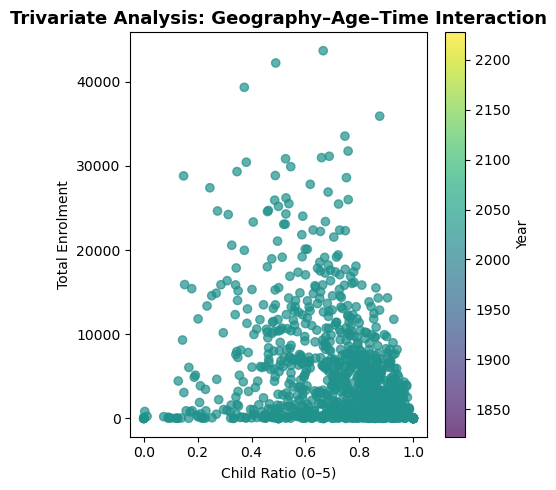

In [55]:
plt.figure(figsize=(5, 5))

scatter = plt.scatter(
    district_year_df['child_ratio'],
    district_year_df['total_enrolment'],
    c=district_year_df['year'],
    cmap='viridis',
    alpha=0.7
)

plt.colorbar(scatter, label='Year')

plt.title("Trivariate Analysis: Geography–Age–Time Interaction",
          fontsize=13, fontweight='bold')
plt.xlabel("Child Ratio (0–5)")
plt.ylabel("Total Enrolment")

plt.tight_layout()
plt.savefig("slide6_trivariate_analysis.png", dpi=300)
plt.show()


In [59]:
final_df = district_year_df.drop(columns=['pincode'])


In [61]:
final_df['state'] = final_df['state'].replace({
    'Westbengal': 'West Bengal'
})


In [63]:
final_df.to_csv(
    "aisi_district_results.csv",
    index=False
)
